# Practical Machine Learning Tutorial with Python Introduction

Reference: https://pythonprogramming.net

## 1. Regression 

The goal is to take continuous data, find the equation that best fits the data, and be able forecast out a specific value. With simple linear regression, you are just simply doing this by creating a best fit line.

<img src="images/linear-regression-algorithm-tutorial-test.png" >
<caption><center>**Figure 1**</center></caption><br>


In [35]:
import quandl
import math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
style.use('ggplot')

Check https://www.quandl.com/ 

In [14]:
df = quandl.get('WIKI/GOOGL')

In [15]:
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

Regression is a form of supervised machine learning, which is where the scientist teaches the machine by showing it features and then showing it what the correct answer is, over and over, to teach the machine. Once the machine is taught, the scientist will usually "test" the machine on some unseen data, where the scientist still knows what the correct answer is, but the machine doesn't. The machine's answers are compared to the known answers, and the machine's accuracy can be measured. If the accuracy is high enough, the scientist may consider actually employing the algorithm in the real world.

**Data, Features and Labels**

In [16]:
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.072956    0.324968   44659000.0
2004-08-20   54.322689  7.921706    7.227007   22834300.0
2004-08-23   54.869377  4.049360   -1.227880   18256100.0
2004-08-24   52.597363  7.657099   -5.726357   15247300.0
2004-08-25   53.164113  3.886792    1.183658    9188600.0


Here, we define the forecasting column, then we fill any NaN data with -99999.

In [20]:
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)

we want for instance 10% of the last data.


In [30]:
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.072956    0.324968   44659000.0  69.639972
2004-08-20   54.322689  7.921706    7.227007   22834300.0  69.078238
2004-08-23   54.869377  4.049360   -1.227880   18256100.0  67.839414
2004-08-24   52.597363  7.657099   -5.726357   15247300.0  68.912727
2004-08-25   53.164113  3.886792    1.183658    9188600.0  70.668146


In [24]:
print(df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume  label
Date                                                            
2018-03-21     1094.00  1.964351    0.130884    1990515.0    NaN
2018-03-22     1053.15  3.254997   -2.487014    3418154.0    NaN
2018-03-23     1026.55  4.082607   -2.360729    2413517.0    NaN
2018-03-26     1054.09  4.619150    0.332191    3272409.0    NaN
2018-03-27     1006.94  6.645878   -5.353887    2940957.0    NaN


**Training and Testing**

In [31]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [26]:
clf = svm.SVR()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.8103274434725403


In [28]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.9758678311425439


In [29]:
for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence)

linear 0.9744430970594726
poly 0.6485138190964823
rbf 0.8103274434725403
sigmoid 0.9027371471107171


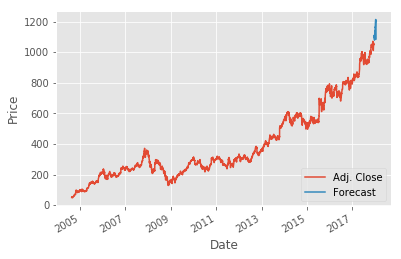

In [36]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
